# Test cascade failure dynamic

In [1]:
# Test cascading dynamic on a single food product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [2]:
# FUNCTIONS
def Trade_preferences (data_trade,unique_ISO): 
    # Define trade matrix
    matrix_trade = data_trade.pivot(index = 'origin_country_ISO',columns='destin_country_ISO',values='value').fillna(0)
    row_sum= matrix_trade.sum(axis=1) #axis =1 is rownorm
    row_sum= row_sum[row_sum>0]

    # Remove rows with zero sum 
    matrix_trade_simp= matrix_trade.loc[row_sum.index,:] 
    df_trade_simp = pd.DataFrame(matrix_trade_simp, columns=matrix_trade_simp.index, index=matrix_trade_simp.columns) 
    inv_sum = np.diag(1/row_sum.to_numpy())

    # Get matrix multiplication
    W = np.matmul(inv_sum,matrix_trade_simp.to_numpy())
    W_df = pd.DataFrame(W,columns=df_trade_simp.index,index=df_trade_simp.columns)

    # Update
    W_all = pd.DataFrame(np.zeros([len(unique_ISO),len(unique_ISO)]), columns=unique_ISO, index=unique_ISO) # should be 190
    W_all.update(W_df)

    # Save also trade matrix complete
    df_trade_all = pd.DataFrame(np.zeros([len(unique_ISO),len(unique_ISO)]), columns=unique_ISO, index=unique_ISO) # should be 190
    df_trade_all.update(matrix_trade)
    df_trade_all.rename_axis('destin_country_ISO', axis='columns',inplace=True)
    df_trade_all.rename_axis('origin_country_ISO', axis='index',inplace=True)

    return W_all, df_trade_all


In [3]:
# Load data
data_trade_og = pd.read_pickle('../Data/Data_trade_filt_production.pkl')
data_prod_og = pd.read_pickle('../Data/Data_prod_filt_production.pkl')
data_prod_og['unit'].replace({'t':'tonnes'},inplace=True)
print(len(data_trade_og.item.unique()))

#Extract list of all countries 
countries_iso = data_trade_og[['origin_country','origin_country_ISO']].rename(columns={'origin_country':'country','origin_country_ISO':'ISO'})
countries_iso = pd.concat([countries_iso,data_trade_og[['destin_country','destin_country_ISO']].rename(columns={'destin_country':'country','destin_country_ISO':'ISO'})])
countries_iso = countries_iso.drop_duplicates().sort_values(by='country')

countries_iso

216


,country,ISO
96120,Afghanistan,AF
118990,Albania,AL
14665,Algeria,DZ
195495,Angola,AO
582661,Antigua and Barbuda,AG
...,...,...
21300329,Wake Island,UM-79
82137,Yemen,YE
585995,Yugoslav SFR,YU
133261,Zambia,ZM


In [4]:
data_prod_og.unit.unique()

array(['tonnes', '1000 No'], dtype=object)

In [5]:
# Take one product & year to work with: testing with wheat
data_trade = data_trade_og.loc[(data_trade_og.item_code ==15) & (data_trade_og.year ==2019) &  (data_trade_og.unit =='tonnes') ].reset_index(drop=True)
data_prod = data_prod_og.loc[(data_prod_og.item_code ==15) & (data_prod_og.year ==2019) & (data_prod_og.unit =='tonnes') ].reset_index(drop=True)

data_trade['value'] = data_trade['value']#.round(0)
data_prod['value'] = data_prod['value']#.round(0)

data_prod = pd.merge(data_prod, countries_iso, left_on= 'area',right_on='country',how='left')
data_prod

unique_ISO = list(sorted(set(data_trade.origin_country_ISO.unique()).union(data_trade.destin_country_ISO.unique()).union(data_prod.ISO.unique())))

# Simplify datasets to work better: 
data_prod= data_prod.loc[:,['ISO','value']]
data_trade_filt = data_trade.loc[:,['origin_country_ISO','destin_country_ISO','value']].reset_index(drop=True)
data_trade_filt = data_trade_filt.loc[data_trade_filt.value>0,:]

In [6]:
# Estimate preferences Trade
W, df_trade_all = Trade_preferences(data_trade_filt, unique_ISO)
df_trade_all

Adj = 1*(W>0)
Adj

,AE,AF,AG,AL,AM,AO,AR,AT,AU,AZ,...,UZ,VC,VE,VN,VU,WS,YE,ZA,ZM,ZW
AE,0,1,0,0,1,1,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0
AF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YE,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZA,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
ZM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
   
def Estimate_demand (trade_in, data_prod):
    # Estimate trade from previous timestep:
    in_group = trade_in.groupby(by = 'destin_country_ISO').value.sum()#.round(2) #imports 
    prod_group = data_prod.groupby(by='ISO').value.sum() #.round(2) # production
    ex_group = trade_in.groupby(by = 'origin_country_ISO').value.sum()#.round(2)

    # Define aggregate trade per country: 
    available_product = pd.merge(prod_group, in_group, left_index=True, right_index=True,how='outer',suffixes=['_prod','_import']).fillna(0)
    available_product = pd.merge(available_product, ex_group, left_index=True, right_index=True,how='outer').fillna(0)# exports
    available_product.columns= ['production','imports','exports']

    # Define demand
    demand = (available_product['production'] + available_product['imports'] - available_product['exports']).round(2) #.round(6)
    #iso_list = list(set(trade_in.origin_country_ISO.unique()).union(trade_in.destin_country_ISO.unique()).union(data_prod.ISO))
    #demand = pd.DataFrame(np.zeros(iso_list),
    return demand

# Test iterations simulation
demand = Estimate_demand(data_trade_filt, data_prod) 


In [ ]:
# PLOT NETWORK
import networkx as nx

country_metadata = pd.read_pickle('../Data/Country_info.pkl')

country_metadata_filt = country_metadata.loc[country_metadata['ISO'].isin(unique_ISO),:]

def Make_nx_graph (data_trade_filt, country_metadata_filt):
    pos_dict = country_metadata_filt.loc[:,['ISO','pos','name']].set_index('ISO').to_dict(orient='index')
    edge_list= list(data_trade_filt.to_records(index=False))

    # Create network:
    G=nx.Graph()
    G.add_nodes_from(pos_dict)
    nx.set_node_attributes(G,pos_dict)
    G.add_weighted_edges_from(edge_list)

    # Remove countries without geometry position (only for plotting reasons)
    G_plot= G.copy()
    no_geometry = list(country_metadata_filt.loc[country_metadata_filt['pos'].isnull(),'ISO'].values)
    G_plot.remove_nodes_from(no_geometry)

    country_metadata_filt = country_metadata_filt.loc[~country_metadata_filt.ISO.isin(no_geometry),:]
    pos_dict2 = dict(zip(country_metadata_filt.ISO, country_metadata_filt.pos))

    # Remove edges with 0 weight
    to_remove = [(u, v, data) for u, v, data in G_plot.edges(data=True) if 'weight' in data and data['weight'] == 0]
    G_plot.remove_edges_from(to_remove)

    return G_plot, pos_dict2

import networkx as nx
pos_dict = country_metadata_filt.loc[:,['ISO','pos','name']].set_index('ISO').to_dict(orient='index')

edge_list= list(data_trade_filt.to_records(index=False))

# Create network:
G=nx.Graph()
G.add_nodes_from(pos_dict)
nx.set_node_attributes(G,pos_dict)
G.add_weighted_edges_from(edge_list)
node_list=list(G.nodes())

# Remove countries without geometry position (only for plotting reasons)
G_plot= G.copy()
no_geometry = list(country_metadata_filt.loc[country_metadata_filt['pos'].isnull(),'ISO'].values)
G_plot.remove_nodes_from(no_geometry)

country_metadata_filt = country_metadata_filt.loc[~country_metadata_filt.ISO.isin(no_geometry),:]
pos_dict2 = dict(zip(country_metadata_filt.ISO, country_metadata_filt.pos))

# Remove nodes with 0 weight
to_remove = [(u, v, data) for u, v, data in G_plot.edges(data=True) if 'weight' in data and data['weight'] == 0]
G_plot.remove_edges_from(to_remove)


In [ ]:
import networkx as nx

shape_file = pd.read_pickle('../Data/Shapefile_with_positions.pkl')
country_metadata = pd.read_pickle('../Data/Country_info.pkl')

country_metadata_filt = country_metadata.loc[country_metadata['ISO'].isin(unique_ISO),:]

def Make_nx_graph (data_trade_filt, country_metadata_filt):
    pos_dict = country_metadata_filt.loc[:,['ISO','pos','name']].set_index('ISO').to_dict(orient='index')
    edge_list= list(data_trade_filt.to_records(index=False))

    # Create network:
    G=nx.Graph()
    G.add_nodes_from(pos_dict)
    nx.set_node_attributes(G,pos_dict)
    G.add_weighted_edges_from(edge_list)

    # Remove countries without geometry position (only for plotting reasons)
    G_plot= G.copy()
    no_geometry = list(country_metadata_filt.loc[country_metadata_filt['pos'].isnull(),'ISO'].values)
    G_plot.remove_nodes_from(no_geometry)

    country_metadata_filt = country_metadata_filt.loc[~country_metadata_filt.ISO.isin(no_geometry),:]
    pos_dict2 = dict(zip(country_metadata_filt.ISO, country_metadata_filt.pos))

    # Remove edges with 0 weight
    to_remove = [(u, v, data) for u, v, data in G_plot.edges(data=True) if 'weight' in data and data['weight'] == 0]
    G_plot.remove_edges_from(to_remove)

    plot_bool = (~data_trade_filt.origin_country_ISO.isin(no_geometry)) & (~data_trade_filt.destin_country_ISO.isin(no_geometry))
    data_plot = data_trade_filt.loc[plot_bool,:]
    
    return G_plot, pos_dict2, data_plot


In [ ]:

def Plot_nx_graph (G_plot,pos_dict,data_plot, available_product):
    fig , axs = plt.subplots()
    shape_file.plot(figsize=(15, 10),edgecolor='dimgray', facecolor="none",linewidth=0.5,ax = axs)#facecolor='white',

    # get countries 
    ISO_plot = list(set(data_plot.origin_country_ISO.unique()).union(data_plot.destin_country_ISO.unique()))

    available_product_plot= available_product.loc[ISO_plot,:]
    
    pos_id_plot = {key: pos_dict[key] for key in ISO_plot if key in pos_dict}
    xs = list(list(zip(*list(pos_id_plot.values())))[0])
    ys = list(list(zip(*list(pos_id_plot.values())))[1])

    color_mapping = {True: 'red', False: 'lightgray'}
    col = (available_product_plot['failed']>0).replace(color_mapping)

    failed_nodes = available_product_plot.loc[available_product_plot['failed']>0,:].index
    edge_colors = ['black' if u in failed_nodes else 'lightgray' for u, v in G.edges()]

    nx.draw_networkx_edges(G_plot,pos= pos_dict,width=0.5, alpha=0.2, edge_color =edge_colors,ax=axs)

    axs.scatter(xs, ys, s=20, c=col,linewidths=0.2,  alpha=1) #marker='s',edgecolors='.1',edgecolors='.2',
    
    plt.show()

G_plot,pos_dict, data_plot = Make_nx_graph(data_trade_filt, country_metadata_filt)

#Plot_nx_graph(G_plot, pos_dict,data_plot,available_product)


In [ ]:
ISO_plot = list(set(data_plot.origin_country_ISO.unique()).union(data_plot.destin_country_ISO.unique()))

Adj_plot= Adj.loc[ISO_plot,ISO_plot]
sum(Adj_plot.loc['IN',:])

In [ ]:
rel_shock = data_prod.copy()
rel_shock['value']= 0.3*rel_shock['value']
rel_shock['t_shock']= 1
rel_shock

0.0


  0%|          | 0/125 [00:00<?, ?it/s]

/tmp/ipykernel_2679554/4188925194.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_long = pd.concat([final_long,dd_long])
100%|██████████| 125/125 [02:03<00:00,  1.01it/s]


0.1


  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_2679554/4188925194.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_long = pd.concat([final_long,dd_long])
100%|██████████| 125/125 [02:18<00:00,  1.11s/it]


0.2


  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_2679554/4188925194.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_long = pd.concat([final_long,dd_long])
100%|██████████| 125/125 [02:25<00:00,  1.16s/it]


0.3


  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_2679554/4188925194.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_long = pd.concat([final_long,dd_long])
100%|██████████| 125/125 [02:26<00:00,  1.18s/it]


0.4


  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_2679554/4188925194.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_long = pd.concat([final_long,dd_long])
100%|██████████| 125/125 [02:27<00:00,  1.18s/it]


0.5


  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_2679554/4188925194.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_long = pd.concat([final_long,dd_long])
100%|██████████| 125/125 [02:28<00:00,  1.19s/it]


0.6


  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_2679554/4188925194.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_long = pd.concat([final_long,dd_long])
100%|██████████| 125/125 [02:27<00:00,  1.18s/it]


0.7


  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_2679554/4188925194.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_long = pd.concat([final_long,dd_long])
100%|██████████| 125/125 [02:28<00:00,  1.19s/it]


0.8


  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_2679554/4188925194.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_long = pd.concat([final_long,dd_long])
100%|██████████| 125/125 [02:28<00:00,  1.19s/it]


0.9


  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_2679554/4188925194.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_long = pd.concat([final_long,dd_long])
100%|██████████| 125/125 [02:29<00:00,  1.20s/it]


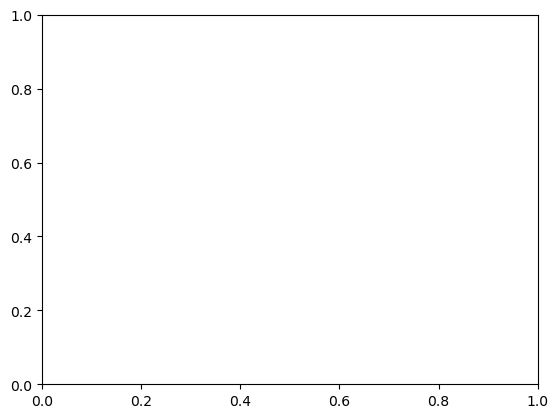

In [99]:
import matplotlib
def Plot_nx_graph (G_plot,pos_dict,data_plot, available_product):

    fig , axs = plt.subplots()
    shape_file.plot(figsize=(15, 10),edgecolor='dimgray', facecolor="none",linewidth=0.5,ax = axs)#facecolor='white',

    # get countries 
    ISO_plot = list(set(data_plot.origin_country_ISO.unique()).union(data_plot.destin_country_ISO.unique()))

    available_product_plot= available_product.loc[ISO_plot,:]
    
    pos_id_plot = {key: pos_dict[key] for key in ISO_plot if key in pos_dict}
    xs = list(list(zip(*list(pos_id_plot.values())))[0])
    ys = list(list(zip(*list(pos_id_plot.values())))[1])

    color_mapping = {True: 'red', False: 'lightgray'}
    col = (available_product_plot['failed']>0).replace(color_mapping)

    failed_nodes = list(available_product_plot.loc[available_product_plot['failed']>0,:].index)
    #edge_colors = ['red' if edge[0] in failed_nodes else 'yellow' for edge in G.edges()]
    failed_edges = [ edge for edge in G_plot.edges() if edge[0] in failed_nodes]
    non_failed = [ edge for edge in G_plot.edges() if (edge[0] in failed_nodes)==False]

    #nx.draw_networkx_edges(G_plot,pos= pos_dict,width=0.5, alpha=0.2, edge_color =edge_colors,ax=axs)
    nx.draw_networkx_edges(G_plot,pos= pos_dict,edgelist=non_failed, alpha= 0.2,width=0.5, edge_color ='lightgray',ax=axs)
    nx.draw_networkx_edges(G_plot,pos= pos_dict,edgelist=failed_edges,width=0.5, edge_color ='black',ax=axs)

    axs.scatter(xs, ys, s=20, c=col,linewidths=0.2,  alpha=1) #marker='s',edgecolors='.1',edgecolors='.2',
    
    plt.show()

def Iteration_simulation(trade_in, data_prod, shocks, it):  
    # Apply shock to production
    shock_t = shocks.loc[shocks.t_shock== it,:]
    #print(shock_t)

    if len(shock_t) > 0:
        shock_t.index= shocks.ISO
        data_prod_new = data_prod.copy()
        data_prod_new.index = data_prod_new.ISO
        data_prod_new.loc[shock_t.ISO,'value'] = data_prod_new.loc[shock_t.ISO,'value'] - shock_t.loc[:,'value']
        data_prod_new.reset_index(drop=True,inplace=True)
    else: 
        data_prod_new = data_prod.copy()

    # Estimate trade from previous timestep:
    in_group = trade_in.groupby(by = 'destin_country_ISO').value.sum().round(2) #imports 
    prod_group = data_prod_new.groupby(by='ISO').value.sum().round(2) # production
    ex_group = trade_in.groupby(by = 'origin_country_ISO').value.sum().round(2)

    # Define aggregate trade per country: 
    available_product = pd.merge(prod_group, in_group, left_index=True, right_index=True,how='outer',suffixes=['_prod','_import']).fillna(0)
    available_product = pd.merge(available_product, ex_group, left_index=True, right_index=True,how='outer').fillna(0)# exports
    available_product.columns= ['production','imports','exports']

    # Define estimate of drop in product available: 
    available_product['avail_prod'] = (available_product['production'] + available_product['imports']).round(2)
    available_product['expected_dd']  = (demand - available_product['avail_prod'] + available_product['exports']).round(2)

    # replace isclose by 0: 
    #available_product.loc[np.isclose(available_product['expected_dd'],0.0, atol=1e-9),'expected_dd']=0

    # Estimate change in total exports of the country 
    export_reduction =  pd.concat([available_product['exports'], available_product['expected_dd']], axis=1).min(axis=1)
    available_product['export_reduction'] = export_reduction
    
    available_product['final_dd']  = (available_product['expected_dd'] - available_product['export_reduction']).round(2)

    available_product.loc[:,'exports_new'] = (available_product['exports'] - export_reduction).round(2)

    available_product['failed']= 0
    available_product['failed']= 1*(available_product['final_dd']>0)
                                  
    #available_product = available_product.round(2)
    #print(str(it)+' => ex: ',np.round(sum(available_product['exports']),2),\
    #      ' dd: ',np.round(sum(available_product['expected_dd']),2),\
    #      ' exp_new: ',np.round(sum(available_product['exports_new']),2),\
    #      ' final_dd: ', np.round(sum(available_product['final_dd']),2),\
    #      ' reduction: ', np.round(sum(available_product['export_reduction']),2),\
    #      'failed: ',sum(available_product['failed']))
    
    # Propagate the reduction on trade to neighbours:
    next_exports = np.diag(available_product['exports_new'])
    df_trade_new =np.matmul(next_exports, W)
    df_trade_new.index = available_product.index

    # Transform data to long format
    data_trade_new= df_trade_new.stack().reset_index()
    data_trade_new.columns= ['origin_country_ISO','destin_country_ISO','value']

    return data_trade_new, available_product, df_trade_new
 
max_t= 100#350
in_trade = data_trade_filt.copy()
#shocks = pd.DataFrame([['IN',1e4, 1]],columns=['ISO','magnitude','t_shock'])
rel_reduct_list = np.arange(0,1,0.1).round(2)
cmap = matplotlib.colormaps['viridis']


long_dict = dict()
for rel in rel_reduct_list:
    print(rel)
    # Relative shock defnition 
    rel_shock = data_prod.copy()
    rel_shock['value']= rel*rel_shock['value']
    rel_shock['t_shock']= 1
    #
    final_dd = pd.DataFrame(index=unique_ISO)
    #final_long = pd.DataFrame(columns= ['ISO_affected','time','value','shock_ISO']) 
    final_long = pd.DataFrame(columns= ['ISO_affected','time','value','shock_ISO']) 

    for c in tqdm(range(len(rel_shock))):
        in_trade = data_trade_filt.copy()
        data_prod = data_prod.copy()
        shocks= pd.DataFrame([rel_shock.loc[c,:]])
        #print(shocks)
        final_dd =  pd.DataFrame(index=unique_ISO)
        for it in range(1,max_t):
            in_trade, available_product, df_trade_new = Iteration_simulation(in_trade, data_prod, shocks, it) 
            #save_failed.append(sum(available_product['failed']))
            
            final_dd.loc[:,it] = available_product['final_dd']
            # Plot_nx_graph(G_plot, pos_dict,data_plot,available_product)
            #in_trade=in_trade.loc[in_trade.value>0,:]
            # Agg value 
        dd_long = final_dd.reset_index().melt(id_vars='index', var_name='time')
        dd_long.columns= ['ISO_affected','time','value']
        #print(shocks.ISO)
        dd_long.loc[:,'shock_ISO']= shocks.ISO[c]
        final_long = pd.concat([final_long,dd_long])
    long_dict[rel] = final_long

In [102]:
long_dict[0.3]

,ISO_affected,time,value,shock_ISO
0,AE,1,0.0,AF
1,AF,1,1467000.0,AF
2,AG,1,0.0,AF
3,AL,1,0.0,AF
4,AM,1,0.0,AF
...,...,...,...,...
18805,WS,99,0.0,ZW
18806,YE,99,0.0,ZW
18807,ZA,99,0.0,ZW
18808,ZM,99,0.0,ZW


In [113]:
mcolors.TABLEAU_COLORS

{'b': (0, 0, 1),
 'g': (0, 0.5, 0),
 'r': (1, 0, 0),
 'c': (0, 0.75, 0.75),
 'm': (0.75, 0, 0.75),
 'y': (0.75, 0.75, 0),
 'k': (0, 0, 0),
 'w': (1, 1, 1)}

0.0


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


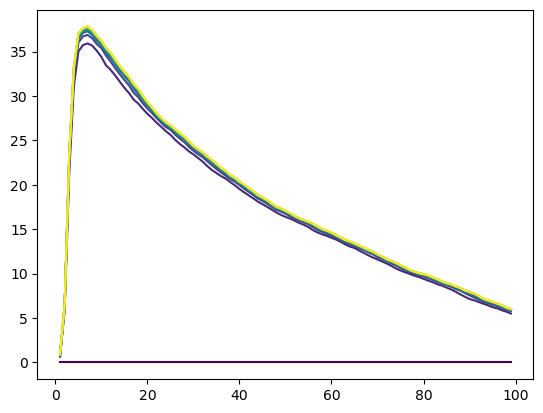

In [120]:
# PLOT 
import matplotlib.colors as mcolors

import cycler

n = len(rel_reduct_list)
color = plt.cm.viridis(np.linspace(0, 1, n))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig, ax = plt.subplots(1)

for it, rel in enumerate(rel_reduct_list):
    print(rel)
    mean_dd = long_dict[rel].groupby(by=['shock_ISO','time'],as_index=False).apply(lambda group: len(group.loc[group.value>0,'value']))
    mean_dd.columns = ['shocks_ISO','time','count_f']

    mean_av = mean_dd.groupby(by = 'time',as_index=False).count_f.mean()
    quantiles = mean_dd.groupby(by = 'time',as_index=False).apply(lambda group:  group.loc[group.count_f>0,'count_f'].quantile([0.025,0.975])).fillna(0)# 25% samples down
    ax.plot(mean_av['time'],mean_av['count_f'],label =str(rel))
    # ax.fill_between(range(1,max_t), quantiles[0.025],quantiles[0.975], alpha=.3, color='#4b1d95', zorder=2)
plt.show()


In [9]:
final_long

,ISO_affected,time,value,shock_ISO
0,AE,1,0.0,AF
1,AF,1,489000.0,AF
2,AG,1,0.0,AF
3,AL,1,0.0,AF
4,AM,1,0.0,AF
...,...,...,...,...
15005,WS,79,0.0,ZW
15006,YE,79,0.0,ZW
15007,ZA,79,0.0,ZW
15008,ZM,79,0.0,ZW


ValueError: '#red' is not a valid color value.

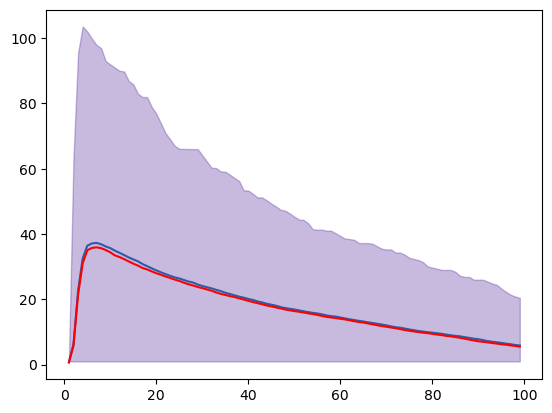

In [84]:
mean_dd = final_long.groupby(by=['shock_ISO','time'],as_index=False).apply(lambda group: len(group.loc[group.value>0,'value']))
mean_dd.columns = ['shocks_ISO','time','count_f']

mean_av = mean_dd.groupby(by = 'time',as_index=False).count_f.mean()
quantiles = mean_dd.groupby(by = 'time',as_index=False).apply(lambda group:  group.loc[group.count_f>0,'count_f'].quantile([0.025,0.975]))# 25% samples down

fig, ax = plt.subplots(1)
ax.plot(mean_av['time'],mean_av['count_f'])
ax.fill_between(range(1,max_t), quantiles[0.025],quantiles[0.975], alpha=.3, color='#4b1d95', zorder=2)

# 2nd plot 
mean_dd = final_long2.groupby(by=['shock_ISO','time'],as_index=False).apply(lambda group: len(group.loc[group.value>0,'value']))
mean_dd.columns = ['shocks_ISO','time','count_f']

mean_av = mean_dd.groupby(by = 'time',as_index=False).count_f.mean()
quantiles = mean_dd.groupby(by = 'time',as_index=False).apply(lambda group:  group.loc[group.count_f>0,'count_f'].quantile([0.025,0.975]))# 25% samples down

ax.plot(mean_av['time'],mean_av['count_f'],color='red')
ax.fill_between(range(1,max_t), quantiles[0.025],quantiles[0.975], alpha=.3, color='#red', zorder=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Failed countries')
ax.set_title('Av. num failed countries')

plt.show()

In [81]:
mean_av

,time,None
0,1,1.000000
1,2,10.371429
2,3,30.295455
3,4,43.111111
4,5,49.750000
...,...,...
94,95,12.156250
95,96,11.906250
96,97,11.484375
97,98,11.171875


In [ ]:
mean_dd = final_long.groupby(by=['shock_ISO','time'],as_index=False).apply(lambda group:len(group.loc[group.value>0,:]))
mean_dd



In [ ]:

def Start_it (G_plot,pos_dict,data_plot):
    base = shape_file.plot(edgecolor='dimgray', facecolor="none",linewidth=0.5,ax = axs)#facecolor='white',figsize=(15, 10)

    return base

def Plot_nx_graph (G_plot,pos_dict,data_plot, available_product,it):
    shape_file.plot(edgecolor='dimgray', facecolor="none",linewidth=0.5,ax = axs)#facecolor='white',figsize=(15, 10)

    # get countries 
    ISO_plot = list(set(data_plot.origin_country_ISO.unique()).union(data_plot.destin_country_ISO.unique()))

    available_product_plot= available_product.loc[ISO_plot,:]
    
    pos_id_plot = {key: pos_dict[key] for key in ISO_plot if key in pos_dict}
    xs = list(list(zip(*list(pos_id_plot.values())))[0])
    ys = list(list(zip(*list(pos_id_plot.values())))[1])

    color_mapping = {True: 'red', False: 'lightgray'}
    col = (available_product_plot['failed']>0).replace(color_mapping)

    failed_nodes = list(available_product_plot.loc[available_product_plot['failed']>0,:].index)
    #edge_colors = ['red' if edge[0] in failed_nodes else 'yellow' for edge in G.edges()]
    failed_edges = [ edge for edge in G_plot.edges() if edge[0] in failed_nodes]
    non_failed = [ edge for edge in G_plot.edges() if (edge[0] in failed_nodes)==False]

    #nx.draw_networkx_edges(G_plot,pos= pos_dict,width=0.5, alpha=0.2, edge_color =edge_colors,ax=axs)
    nx.draw_networkx_edges(G_plot,pos= pos_dict,edgelist=non_failed, alpha= 0.2,width=0.5, edge_color ='lightgray',ax=axs)
    nx.draw_networkx_edges(G_plot,pos= pos_dict,edgelist=failed_edges,width=0.5, edge_color ='black',ax=axs)

    axs.scatter(xs, ys, s=20, c=col,linewidths=0.2,  alpha=1) #marker='s',edgecolors='.1',edgecolors='.2',
    axs.set_title('Iteration: ',str(it)) #marker='s',edgecolors='.1',edgecolors='.2',



# ANIMATE 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

# Create Graph
G_plot,pos_dict, data_plot = Make_nx_graph(data_trade_filt, country_metadata_filt)

# Build plot
max_t= 350
in_trade = data_trade_filt.copy()
shocks = pd.DataFrame([['IN',1, 1e4]],columns=['ISO','t_shock','magnitude'])
save_failed = [0]

fig, axs = plt.subplots(figsize=(6,4))
axs = Start_it (G_plot,pos_dict,data_plot)


In [ ]:

# test t0
fig , axs = plt.subplots()
available_product = av_prod_time[1]
shape_file.plot(edgecolor='dimgray', facecolor="none",linewidth=0.5,ax = axs)#facecolor='white',figsize=(15, 10)

# get countries 
ISO_plot = list(set(data_plot.origin_country_ISO.unique()).union(data_plot.destin_country_ISO.unique()))

available_product_plot= available_product.loc[ISO_plot,:]

pos_id_plot = {key: pos_dict[key] for key in ISO_plot if key in pos_dict}
xs = list(list(zip(*list(pos_id_plot.values())))[0])
ys = list(list(zip(*list(pos_id_plot.values())))[1])
scat = axs.scatter(xs, ys, c='lightgray')

def update_plot(i, av_prod_time,data_plot, scat):
    axs.clear()

    available_product = av_prod_time[i+1]
    ISO_plot = list(set(data_plot.origin_country_ISO.unique()).union(data_plot.destin_country_ISO.unique()))
    pos_id_plot = {key: pos_dict[key] for key in ISO_plot if key in pos_dict}
    xs = list(list(zip(*list(pos_id_plot.values())))[0])
    ys = list(list(zip(*list(pos_id_plot.values())))[1])
    scat.set_offsets(xs,ys)
    #scat.scatter(xs,ys,color ='b')
    return scat,

def update(it):
    available_product = av_prod_time[it+1]
    shape_file.plot(edgecolor='dimgray', facecolor="none",linewidth=0.5,ax = axs)#facecolor='white',figsize=(15, 10)

    # get countries 
    ISO_plot = list(set(data_plot.origin_country_ISO.unique()).union(data_plot.destin_country_ISO.unique()))

    available_product_plot= available_product.loc[ISO_plot,:]
    
    pos_id_plot = {key: pos_dict[key] for key in ISO_plot if key in pos_dict}
    xs = list(list(zip(*list(pos_id_plot.values())))[0])
    ys = list(list(zip(*list(pos_id_plot.values())))[1])

    color_mapping = {True: 'red', False: 'lightgray'}
    col = (available_product_plot['failed']>0).replace(color_mapping)

    failed_nodes = list(available_product_plot.loc[available_product_plot['failed']>0,:].index)
    #edge_colors = ['red' if edge[0] in failed_nodes else 'yellow' for edge in G.edges()]
    failed_edges = [ edge for edge in G_plot.edges() if edge[0] in failed_nodes]
    non_failed = [ edge for edge in G_plot.edges() if (edge[0] in failed_nodes)==False]

    #nx.draw_networkx_edges(G_plot,pos= pos_dict,width=0.5, alpha=0.2, edge_color =edge_colors,ax=axs)
    nx.draw_networkx_edges(G_plot,pos= pos_dict,edgelist=non_failed, alpha= 0.2,width=0.5, edge_color ='lightgray',ax=axs)
    nx.draw_networkx_edges(G_plot,pos= pos_dict,edgelist=failed_edges,width=0.5, edge_color ='black',ax=axs)

    axs.scatter(xs, ys, s=20, c=col,linewidths=0.2,  alpha=1) #marker='s',edgecolors='.1',edgecolors='.2',
    axs.set_title('Iteration '+ str(it+1)) #marker='s',edgecolors='.1',edgecolors='.2',
   
ani = matplotlib.animation.FuncAnimation(fig, update_plot,  frames=range(1,20), interval=20, fargs=(av_prod_time, data_plot, scat) ,repeat=True)

plt.show()

In [ ]:
plt.plot(save_failed)

In [ ]:
sum(available_product['failed'])

In [ ]:
imp_t0.loc[imp_t0['destin_country_ISO'] =='AG',:].value.sum()

In [ ]:
(demand + available_product['exports'] - available_product['production'] - available_product['imports']).round(2)

In [ ]:
available_product.loc['AG',:]

In [ ]:
available_product.loc['AG',:]

In [ ]:
demand['AG']

In [ ]:

# Iteration
#data_trade1, data_prod1, available_product1 = Iteration_simulation(data_trade_filt, data_prod, shocks, 1) 
#data_trade_new2, data_prod_new2,available_product2 = Iteration_simulation(data_trade1, data_prod, shocks, 2) 
data_trade_new3, data_prod_new3,available_product3 = Iteration_simulation(data_trade_new2, data_prod, shocks, 3) 
data_trade_new5, data_prod_new5,available_product5 = Iteration_simulation(data_trade_new3, data_prod, shocks, 4) 



In [ ]:
data_trade_new3, data_prod_new3,available_product3 = Iteration_simulation(data_trade_new2, data_prod, shocks, 3) 

#data_trade_new, data_prod_new, demand = Iteration_simulaiton(data_trade_filt, data_prod, demand, shocks, 1) 


In [ ]:
available_product.loc[np.isclose(available_product['expected_dd'],0.0, atol=1e-9),'expected_dd']=0
available_product

In [ ]:
available_product['expected_dd']

In [ ]:
available_product1['drop_demand']

In [ ]:
available_product2['drop_demand']

In [ ]:
df_trade1.loc['AE',:]

In [ ]:
data_trade_new2

In [ ]:
sum(data_trade_filt.sort_values(by=['origin_country_ISO','destin_country_ISO']).reset_index(drop=True).value == data_trade2.sort_values(by=['origin_country_ISO','destin_country_ISO']).reset_index(drop=True).value)

In [ ]:

# Timestep 0:
in_group = data_trade.groupby(by = 'destin_country_ISO').value.sum()#.round(2) #imports
prod_group = data_prod.groupby(by='ISO').value.sum() #.round(2) # production
ex_group = data_trade.groupby(by = 'origin_country_ISO').value.sum()#.round(2)

available_product = pd.merge(prod_group, in_group, left_index=True, right_index=True,how='outer',suffixes=['_prod','_import']).fillna(0)
available_product = pd.merge(available_product,ex_group,left_index=True, right_index=True,how='outer').fillna(0)# exports
available_product.columns= ['production','imports','exports']

available_product['avail_prod']= (available_product['production']+available_product['imports']).round(6)
av_product_old = available_product.copy()

# Find demand (assumed to be real dc):
available_product['demand'] = (available_product['avail_prod'] - available_product['exports']).round(6)

# Drop in demand
available_product['drop_demand']  = np.abs(available_product['demand'] - available_product['avail_prod'] + available_product['exports']).round(6)

demand_diag= pd.DataFrame(np.diag(available_product['demand']),columns= available_product.index,index= available_product.index)

av_product_old = available_product.copy()
available_product

In [ ]:
shocks = pd.DataFrame([['ZA',1,1e6],['AF',1,1e6]],columns=['ISO','t_shock','magnitude'])
#shocks.loc[shocks.t_shock==it,:]
shock_t = shocks.loc[shocks.t_shock==1,:]
shock_t.index= shocks.ISO
if len(shock_t) > 0: 
    data_prod_new = data_prod.copy()
    data_prod_new.index = data_prod.ISO
    data_prod_new.loc[shocks.ISO,'value'] = data_prod_new.loc[shocks.ISO,'value'] - shock_t.loc[:,'magnitude']

data_prod_new.reset_index(drop=True)


In [ ]:
    data_prod_new

In [ ]:
shock_t['magnitude']

In [ ]:
# Iteration 1: 
# Update available product t=1: 
prod_modified = data_prod.copy()
prod_modified.loc[prod_modified.ISO=='ZA','value'] -= 1e6

# Update available product
available_product['production'] = prod_modified.groupby('ISO').value.sum()
available_product['production']=available_product['production'].fillna(0)

available_product['avail_prod'] = (available_product['production'] +available_product['imports']).round(6)
available_product['drop_demand']  = (available_product['demand'] - available_product['avail_prod'] + available_product['exports']).round(6)

available_product.loc[:,'exports'] = av_product_old['exports'] - pd.concat([av_product_old['exports'], available_product['drop_demand']],axis=1).min(axis=1)

# Spread lack demand: reduce exports proportionally 
df_trade_new =np.matmul(np.diag(available_product['exports']), W)
df_trade_new.index = available_product.index

# New imports

In [ ]:

# Update available product
available_product['production'] = prod_modified.groupby('ISO').value.sum()
available_product['production']=available_product['production'].fillna(0)

available_product['avail_prod'] = available_product['avail_prod']= (available_product['production'] +available_product['imports']).round(6)
available_product['drop_demand']  = np.abs(available_product['demand'] - available_product['avail_prod'] + available_product['exports']).round(6)


# Find drop demand
dd  = np.abs(available_product['demand'] - available_product['avail_prod'] + available_product['exports']).round(6)


# OLD CODE

In [ ]:

row_sum= matrix_trade.sum(axis=1) #axis =1 is rownorm
row_sum= row_sum[row_sum>0]

# Remove rows with zero sum 
matrix_trade_simp= matrix_trade.loc[row_sum.index,:] 
df_trade_simp = pd.DataFrame(matrix_trade_simp, columns=matrix_trade_simp.index, index=matrix_trade_simp.columns) 
inv_sum = np.diag(1/row_sum.to_numpy())

# Get matrix multiplication
W = np.matmul(inv_sum,matrix_trade_simp.to_numpy())
W_df = pd.DataFrame(W,columns=df_trade_simp.index,index=df_trade_simp.columns)

# Update
W_all = pd.DataFrame(np.zeros([len(unique_ISO),len(unique_ISO)]), columns=unique_ISO, index=unique_ISO) # should be 190
W_all.update(W_df)
W_all

In [ ]:
data_tr

In [ ]:
# Iteration 0: 
# Find available product (t=0):
def Iteration_estimate(data_trade, data_prod, av_product_old):

    # Find group 
    in_group = data_trade.groupby(by = 'destin_country_ISO').value.sum()#.round(2) #imports
    prod_group = data_prod.groupby(by='ISO').value.sum() #.round(2) # production
    ex_group = data_trade.groupby(by = 'origin_country_ISO').value.sum()#.round(2)

    # Define available product
    available_product = pd.merge(prod_group, in_group, left_index=True, right_index=True,how='outer',suffixes=['_prod','_import']).fillna(0)
    available_product = pd.merge(available_product,ex_group,left_index=True, right_index=True,how='outer').fillna(0)# exports
    available_product.columns= ['production','imports','exports']

    av_product_old['avail_prod']= (av_product_old['production']+av_product_old['imports']).round(6)

    # Update drop in demand
    available_product['drop_demand']  = np.abs(av_product_old['demand'] - available_product['avail_prod'] + av_product_old['exports']).round(6)

    av_product_old = available_product.copy()

    # Update trade: 
    
    return 





# Scenario 0
in_group = data_trade.groupby(by = 'destin_country_ISO').value.sum()#.round(2) #imports
prod_group = data_prod.groupby(by='ISO').value.sum() #.round(2) # production
ex_group = data_trade.groupby(by = 'origin_country_ISO').value.sum()#.round(2)

available_product = pd.merge(prod_group, in_group, left_index=True, right_index=True,how='outer',suffixes=['_prod','_import']).fillna(0)
available_product = pd.merge(available_product,ex_group,left_index=True, right_index=True,how='outer').fillna(0)# exports
available_product.columns= ['production','imports','exports']

available_product['avail_prod']= (available_product['production']+available_product['imports']).round(6)
av_product_old = available_product.copy()

# Find demand (assumed to be real dc):
available_product['demand'] = (available_product['avail_prod'] - available_product['exports']).round(6)

# Drop in demand
available_product['drop_demand']  = np.abs(available_product['demand'] - available_product['avail_prod'] + available_product['exports']).round(6)

demand_diag= pd.DataFrame(np.diag(available_product['demand']),columns= available_product.index,index= available_product.index)

av_product_old = available_product.copy()

In [ ]:
available_product['drop_demand']

In [ ]:

# Iteration 1: 
# Update available product t=1: 
prod_modified = data_prod.copy()
prod_modified.loc[prod_modified.ISO=='ZA','value'] -= 1e6

# Update available product
available_product['production'] = prod_modified.groupby('ISO').value.sum()
available_product['production']=available_product['production'].fillna(0)

available_product['avail_prod'] = available_product['avail_prod']= (available_product['production'] +available_product['imports']).round(6)
available_product['drop_demand']  = np.abs(available_product['demand'] - available_product['avail_prod'] + available_product['exports']).round(6)


# Find drop demand
dd  = np.abs(available_product['demand'] - available_product['avail_prod'] + available_product['exports']).round(6)

# Countries affected: 
np.diag(dd)* W_df




In [ ]:
available_product

In [ ]:
# Iteration 1: 
# Update available product t=1: 
prod_modified = data_prod.copy()
prod_modified.loc[prod_modified.ISO=='RU','value'] -= 20e6
prod_modified

# test Delta d
dd  = available_product['demand'] - available_product['imports'] - available_product['production'] + ex_group

# Find drop in demand
in_group = data_trade.groupby(by = 'destin_country_ISO').value.sum() #imports
prod_group = prod_modified.groupby(by='ISO').value.sum() # production

available_product = pd.merge(prod_group, in_group, left_index=True, right_index=True,how='outer',suffixes=['_prod','_import']).fillna(0)
available_product['avail_prod']= available_product['value_prod']+available_product['value_import']

delta_available= available_product['avail_prod']- av_product_old['avail_prod']

dd


In [ ]:
# IN-trade sum all years:  
in_trade_tot = data_trade.groupby(by = 'destin_country').value.sum()
production_tot= data_prod.groupby(by='area').value.sum()
out_product_tot =  data_trade.groupby(by='origin_country').value.sum()
all_keys_tot = list(set(in_trade_tot.keys()).union(production_tot.keys()).union(out_product_tot.keys()))
all_keys_tot

In [ ]:

def Available_product(in_trade, production, out_product, key_pair):

    imports = 0
    if key_pair in in_trade.keys() :
        imports =  in_trade[key_pair]
    
    prod = 0
    if key_pair in production.keys() :
        prod =  production[key_pair]

    available_product = imports + prod

    # output 
    exported_product = 0
    if key_pair in out_product.keys() :
        #print('output:', out_product[key_pair])
        exported_product= out_product[key_pair]

    # DOMESTIC CONSUMPTION 
    dom_con = available_product - exported_product

    if type(key_pair) is str:
        return_file =[key_pair,'All',imports, prod, available_product,exported_product,dom_con]
    else:
        return_file =[key_pair[0],key_pair[1],imports, prod, available_product,exported_product,dom_con]

    return return_file

#out_data = [Available_product(in_trade, production, out_product, key_pair) for key_pair in all_keys]
#data_check = pd.DataFrame(out_data,columns = ['country','year','imports','production','avail_prod','export_product','domest_consum'])

# Check total sum all years: 
out_data_tot = [Available_product(in_trade_tot, production_tot, out_product_tot, key_pair) for key_pair in all_keys_tot]
data_check_tot = pd.DataFrame(out_data_tot,columns = ['country','year','imports','production','avail_prod','export_product','domest_consum'])

In [ ]:
# Focus on the 2019 wheat trade: 
#df1= data_trade.loc[:,['origin_country_ISO','origin_country']].rename(columns={'origin_country_ISO':'ISO','origin_country': 'country'})
#df2= data_trade.loc[:,['destin_country_ISO','destin_country']].rename(columns={'destin_country_ISO':'ISO','destin_country': 'country'})
#all_iso = pd.concat([df1, df2],axis=0, ignore_index=True).drop_duplicates()

# Add domestic consumption to trade_list: 
data_agg = pd.merge(data_check_tot, countries_iso, on = 'country')
prod_country_key = data_agg[['ISO','country']]
prod_country_key 
dom_consumption=data_agg.loc[:,['domest_consum','ISO']]
dom_consumption['destin_country_ISO'] = dom_consumption['ISO']
dom_consumption=dom_consumption.rename(columns={'ISO': 'origin_country_ISO','domest_consum':'value'})


In [ ]:
data_trade

In [ ]:
# TRADE MATRIX
df1= data_trade.loc[:,['origin_country_ISO','origin_country']].rename(columns={'origin_country_ISO':'ISO','origin_country': 'country'})
df2= data_trade.loc[:,['destin_country_ISO','destin_country']].rename(columns={'destin_country_ISO':'ISO','destin_country': 'country'})
all_iso = pd.concat([df1, df2, prod_country_key],axis=0, ignore_index=True).drop_duplicates()

df_trade = data_trade.loc[:,['origin_country_ISO','destin_country_ISO','value']]
#df_trade = pd.concat([df_trade, dom_consumption], ignore_index=True)

matrix_trade = df_trade.pivot(index = 'origin_country_ISO',columns='destin_country_ISO',values='value').fillna(0)
matrix_domestic = np.diag(dom_consumption)


# UPDATE MATRIX 
df_trade_all = pd.DataFrame(np.zeros([len(all_iso),len(all_iso)]), columns=all_iso.ISO, index=all_iso.ISO) # should be 190
df_trade_all.update(matrix_trade)
df_trade_all.rename_axis('destin_country_ISO', axis='columns',inplace=True)
df_trade_all.rename_axis('origin_country_ISO', axis='index',inplace=True)
df_trade_all

#Divide by rowsum: D= Id*(1/rowsum)
row_sum= df_trade_all.sum(axis=1) #axis =1 is rownorm

inv_sum = np.diag(1/row_sum.to_numpy())

#Multiply D*W
W = np.matmul(inv_sum,df_trade_all.to_numpy())

W_df = pd.DataFrame(W,columns=df_trade_all.columns,index=df_trade_all.index)
W_df

# Sort data agg
data_agg.index=data_agg.ISO
data_agg = data_agg.loc[all_iso.ISO,:]

In [ ]:
# update test? 
prod_vec = np.array(data_agg.avail_prod)
np.diag(prod_vec)

redivided_share = np.matmul(np.diag(prod_vec),W)

In [ ]:
# old state
og_state = df_trade_all

# 
produciton_old = data_agg.loc['RU','production']
produciton = produciton_old - 20000000

df_trade_all
production_diff = df_trade_all  


In [ ]:
long_data = df_trade_all.unstack().reset_index()
long_data.columns= ['destin_country_ISO','origin_country_ISO','value']
long_data

# in trade: 
imports =  in_trade[key_pair]


In [ ]:
inputs = long_data.groupby('destin_country_ISO').value.sum()
inputs


In [ ]:
df_trade_all

In [ ]:

def Update_states(old_trade, old_production, out_product, key_pair):
    old_trade = df_trade_all

    imports = 0
    if key_pair in in_trade.keys() :
        imports =  in_trade[key_pair]
    
    prod = 0
    if key_pair in production.keys() :
        prod =  production[key_pair]

    available_product = imports + prod

    # output 
    exported_product = 0
    if key_pair in out_product.keys() :
        #print('output:', out_product[key_pair])
        exported_product= out_product[key_pair]

    # DOMESTIC CONSUMPTION 
    dom_con = available_product - exported_product

    if type(key_pair) is str:
        return_file =[key_pair,'All',imports, prod, available_product,exported_product,dom_con]
    else:
        return_file =[key_pair[0],key_pair[1],imports, prod, available_product,exported_product,dom_con]

    return return_file


out_data = [Available_product(in_trade, production, out_product) for key_pair in all_keys]
data_check = pd.DataFrame(out_data,columns = ['country','year','imports','production','avail_prod','export_product','domest_consum'])


In [ ]:
old_trade = df_trade_all
old_trade

In [ ]:
prod_vec = np.array(data_agg.avail_prod)
np.diag(prod_vec)

redivided_share = np.matmul(np.diag(prod_vec),W)

# 

In [ ]:
product_division =W_df.loc['RU',:] * data_agg.loc['RU','avail_prod']


In [ ]:
pd.dot(prod_dc)

In [ ]:
# Sort data agg to get same order than all_iso
data_agg.index=data_agg.ISO
data_agg = data_agg.loc[all_iso.ISO,:]
prod_vec = np.array(data_agg.avail_prod)
# 
av_cons= W.mul(prod_vec)

#avail_prod = av_cons.sum(axis=1)
av_cons.sum(axis=1)

In [ ]:
data_agg

In [ ]:
W